## Importing libraries

In [59]:
## 2) Code cell — Setup and reproducibility

# 2. Setup and reproducibility

# Standard library
from pathlib import Path
import warnings
import math
import os
import sys
import random

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time
import pandas as pd
import seaborn as sns



# Modeling
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    precision_recall_fscore_support,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Lifelines
from lifelines import CoxPHFitter

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)



## Understanding the Dataset

In [60]:
# Path to your local file
path = r"/Users/jvcalventi/Downloads/brca_metabric_clinical_data.tsv"

# Load the dataset
df = pd.read_csv(path, sep="\t")

# Preview the data
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,140.500000,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,84.633333,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,153.300000,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,164.933333,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,18.800000,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


In [61]:
# Column types
df.info()

# Summary statistics for numeric columns
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        2509 non-null   object 
 1   Patient ID                      2509 non-null   object 
 2   Sample ID                       2509 non-null   object 
 3   Age at Diagnosis                2498 non-null   float64
 4   Type of Breast Surgery          1955 non-null   object 
 5   Cancer Type                     2509 non-null   object 
 6   Cancer Type Detailed            2509 non-null   object 
 7   Cellularity                     1917 non-null   object 
 8   Chemotherapy                    1980 non-null   object 
 9   Pam50 + Claudin-low subtype     1980 non-null   object 
 10  Cohort                          2498 non-null   float64
 11  ER status measured by IHC       2426 non-null   object 
 12  ER Status                       24

,count,mean,std,min,25%,50%,75%,max
Age at Diagnosis,2498.0,60.420300,13.032997,21.93,50.920000,61.110000,70.000000,96.290000
Cohort,2498.0,2.900320,1.962216,1.00,1.000000,3.000000,4.000000,9.000000
Neoplasm Histologic Grade,2388.0,2.412060,0.649363,1.00,2.000000,3.000000,3.000000,3.000000
Lymph nodes examined positive,2243.0,1.950513,4.017774,0.00,0.000000,0.000000,2.000000,45.000000
Mutation Count,2358.0,5.590755,3.989171,1.00,3.000000,5.000000,7.000000,81.000000
Nottingham prognostic index,2287.0,4.028787,1.189092,1.00,3.048000,4.044000,5.040000,7.200000
Overall Survival (Months),1981.0,125.244271,76.111772,0.00,60.866667,116.466667,185.133333,355.200000
Relapse Free Status (Months),2388.0,110.293649,77.539698,0.00,41.100000,100.416667,169.875000,389.333333
Number of Samples Per Patient,2509.0,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000
TMB (nonsynonymous),2509.0,6.849746,5.320394,0.00,3.922553,6.537589,9.152624,104.601416


In [62]:
# Count of missing values
df.isnull().sum().sort_values(ascending=False)


3-Gene classifier subtype         745
Tumor Stage                       721
Primary Tumor Laterality          639
Cellularity                       592
Type of Breast Surgery            554
Integrative Cluster               529
HER2 status measured by SNP6      529
Radio Therapy                     529
PR Status                         529
Inferred Menopausal State         529
Hormone Therapy                   529
HER2 Status                       529
Patient's Vital Status            529
Pam50 + Claudin-low subtype       529
Chemotherapy                      529
Overall Survival Status           528
Overall Survival (Months)         528
Lymph nodes examined positive     266
Nottingham prognostic index       222
Mutation Count                    151
Tumor Size                        149
Tumor Other Histologic Subtype    135
Relapse Free Status (Months)      121
Neoplasm Histologic Grade         121
ER status measured by IHC          83
ER Status                          40
Relapse Free

## Removing N/A values from the dataset

In [63]:

# Load
df = pd.read_csv(path, sep="\t")

survival_cols = ["Overall Survival (Months)", "Overall Survival Status"]
df = df.dropna(subset=survival_cols)

print("Dataset size after removing missing survival:", df.shape)


categorical_cols = df.select_dtypes(include=["object"]).columns
numeric_cols = df.select_dtypes(include=["number"]).columns

# Optional: manually ensure correct classification
categorical_cols = categorical_cols.tolist()
numeric_cols = numeric_cols.tolist()


df[categorical_cols] = df[categorical_cols].fillna("Unknown")


for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())


print(df.isnull().sum().sort_values(ascending=False))


Dataset size after removing missing survival: (1981, 39)
Study ID                          0
Relapse Free Status (Months)      0
Mutation Count                    0
Nottingham prognostic index       0
Oncotree Code                     0
Overall Survival (Months)         0
Overall Survival Status           0
PR Status                         0
Radio Therapy                     0
Relapse Free Status               0
Primary Tumor Laterality          0
Number of Samples Per Patient     0
Sample Type                       0
Sex                               0
3-Gene classifier subtype         0
TMB (nonsynonymous)               0
Tumor Size                        0
Tumor Stage                       0
Lymph nodes examined positive     0
Integrative Cluster               0
Patient ID                        0
Pam50 + Claudin-low subtype       0
Sample ID                         0
Age at Diagnosis                  0
Type of Breast Surgery            0
Cancer Type                       0
Cancer 

##### In order to remove the missing values without creating bias/imbalance among the varaibles we replace the missing values with "Unknown" while droping the overall survival status values that were missing.

### Feature Visualization

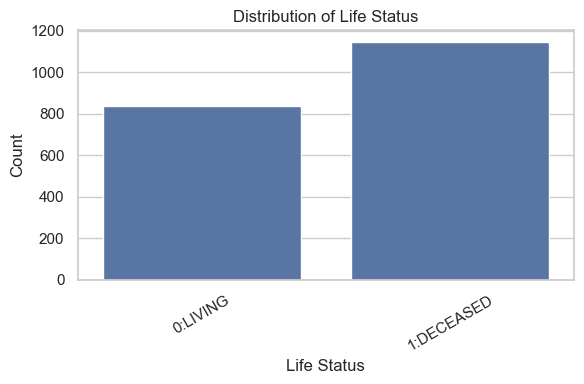

In [64]:
sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(x=df["Overall Survival Status"])
plt.title("Distribution of Life Status")
plt.xlabel("Life Status")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


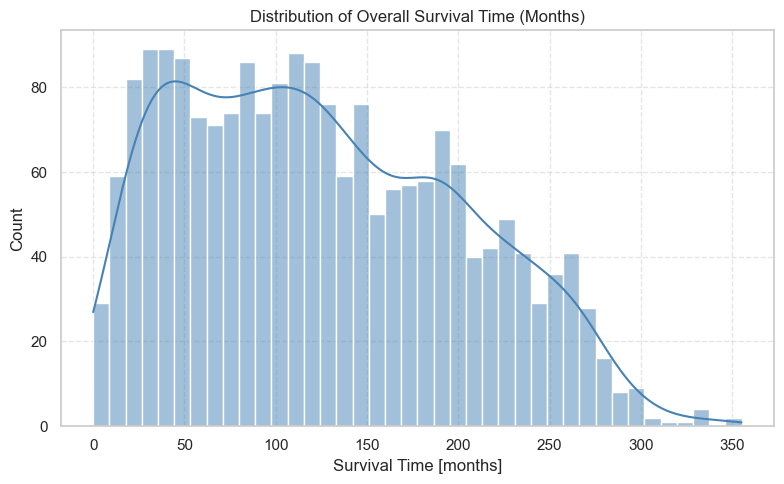

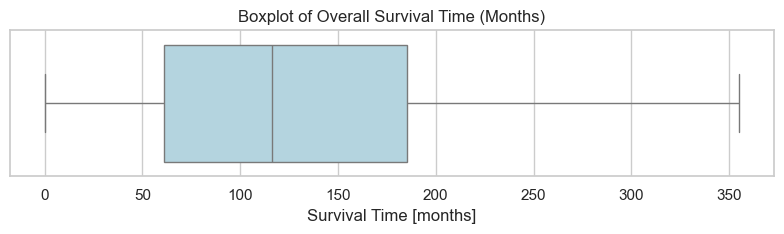

In [65]:
plt.figure(figsize=(8,5))
sns.histplot(df["Overall Survival (Months)"], bins=40, kde=True, color="steelblue")
plt.title("Distribution of Overall Survival Time (Months)")
plt.xlabel("Survival Time [months]")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,2.5))
sns.boxplot(x=df["Overall Survival (Months)"], color="lightblue")
plt.title("Boxplot of Overall Survival Time (Months)")
plt.xlabel("Survival Time [months]")
plt.tight_layout()
plt.show()


## Preprocessing/Splitting

In [66]:
# Create event column (1 = died, 0 = living)
df['event'] = df["Overall Survival Status"].apply(lambda x: 1 if "1:DECEASED" in x else 0)

# Survival time column
df['time'] = df["Overall Survival (Months)"]


In [67]:
# Define features and survival outcomes
X = df.drop(columns=["time", "event", "Overall Survival (Months)", "Overall Survival Status"])
y_time = df["time"]
y_event = df["event"]

# Train/test split WITH stratification on event indicator
X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X, y_time, y_event,
    test_size=0.2,
    random_state=42,
    stratify=y_event
)

print("The following code uses a specific kind of spliting technique for the first model, use the regular kind when preparing your own model")

The following code uses a specific kind of spliting technique for the first model, use the regular kind when preparing your own model


## Kaplan–Meier curves Model

In [69]:
kmf = KaplanMeierFitter(label="All METABRIC patients")
kmf.fit(durations=df["time"], event_observed=df["event"])

kmf.survival_function_.head()


,All METABRIC patients
timeline,
0.000000,1.000000
0.100000,0.999495
0.766667,0.999495
1.233333,0.999495
1.266667,0.999495


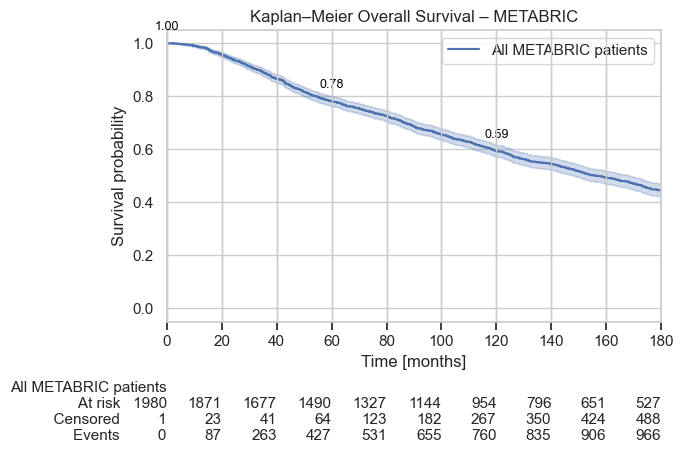

In [70]:
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

# Survival curve
kmf.plot_survival_function(ax=ax)
ax.set_title("Kaplan–Meier Overall Survival – METABRIC")
ax.set_xlabel("Time [months]")
ax.set_ylabel("Survival probability")

# Add gridlines
ax.grid(True)

ax.set_xlim(0, 180)

# Annotate selected time points in months (e.g., 0, 60, 120)
time_points = [0, 60, 120]

for t in time_points:
    # Find the closest time index in the survival function
    idx = kmf.survival_function_.index.get_indexer([t], method="nearest")[0]
    t_closest = kmf.survival_function_.index[idx]
    y = kmf.survival_function_.iloc[idx, 0]

    ax.annotate(f"{y:.2f}",
                xy=(t_closest, y),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center',
                fontsize=9,
                color="black")

add_at_risk_counts(kmf, ax=ax)

plt.tight_layout()
plt.show()


##### The graph above showcases the overall survival probability among the patients up to 180 months. We can see that the survival rate gradually decreases in the course of time as in 60 months (5 years) the survival rate is 78%, in 120 months (10 years) the survival rate is 59% and at 180 months (15 years) about 45% remain alive.

##### Below the graph tells us the amount of patients who are at risk, the patients who are alive at their last follow up or were lost to follow up (censored), and the patients who were confirmed dead from the cancer (events) over the months. As you can see the patients at risk gradually decrease as they are either successfully treated, lost or have passed away.


### Median Survival Time

In [71]:
kmf = KaplanMeierFitter(label="All METABRIC patients")
kmf.fit(df["time"], event_observed=df["event"])

median_survival_time = kmf.median_survival_time_
print(f"The median survival time for the METABRIC cohort is: {median_survival_time:.1f} months")


The median survival time for the METABRIC cohort is: 156.3 months


### Restricted Mean Survival Time

In [72]:
km_overall = KaplanMeierFitter(label="All METABRIC patients").fit(
    df["time"].clip(lower=0),
    df["event"]
)

horizons = [60.0, 120.0, 180.0]

rows = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km_overall, t=t0)
    rows.append({
        "t0 [months]": int(t0),
        "RMST [months]": round(float(rmst_val), 1)
    })

rmst_table = pd.DataFrame(rows)
display(rmst_table)


,t0 [months],RMST [months]
0,60,54.4
1,120,95.7
2,180,126.7


##### We can see that on average ~ 54 patients survive up for 60 months (5 years), ~ 95 patients survive up for 120 months (10 years), and ~ 126 patients survive for 180 months (15 years). 

### Subgroup Reading

In [73]:
candidates = [
    "Age at Diagnosis",
    "Tumor Stage",
    "Neoplasm Histologic Grade",
    "ER Status",
    "PR Status",
    "HER2 Status",
    "Hormone Therapy",
    "Chemotherapy",
    "Radio Therapy"
]

cols = [c for c in candidates if c in df.columns] + ["time", "event"]

display(df[cols].head(8))
display(df[cols].isna().mean().sort_values(ascending=False).to_frame("missing_rate"))

print("Event rate =", df["event"].mean())


,Age at Diagnosis,Tumor Stage,Neoplasm Histologic Grade,ER Status,PR Status,HER2 Status,Hormone Therapy,Chemotherapy,Radio Therapy,time,event
0,75.65,2.0,3.0,Positive,Negative,Negative,YES,NO,YES,140.500000,0
1,43.19,1.0,3.0,Positive,Positive,Negative,YES,NO,YES,84.633333,0
2,48.87,2.0,2.0,Positive,Positive,Negative,YES,YES,NO,163.700000,1
3,47.68,2.0,2.0,Positive,Positive,Negative,YES,YES,YES,164.933333,0
4,76.97,2.0,3.0,Positive,Positive,Negative,YES,YES,YES,41.366667,1
5,78.77,4.0,3.0,Positive,Positive,Negative,YES,NO,YES,7.800000,1
6,56.45,2.0,2.0,Positive,Positive,Negative,YES,YES,YES,164.333333,0
7,70.00,3.0,3.0,Negative,Negative,Negative,NO,YES,YES,22.400000,1


,missing_rate
Age at Diagnosis,0.0
Tumor Stage,0.0
Neoplasm Histologic Grade,0.0
ER Status,0.0
PR Status,0.0
HER2 Status,0.0
Hormone Therapy,0.0
Chemotherapy,0.0
Radio Therapy,0.0
time,0.0


Event rate = 0.5774861181221606


In [74]:
def km_by_group(data, group_col, title=None, order=None, drop_unknown=True):
    """
    Plot KM curves by levels of `group_col` and run a log-rank test.
    """
    df_sub = data.copy()

    if drop_unknown and "Unknown" in df_sub[group_col].values:
        df_sub = df_sub[df_sub[group_col] != "Unknown"]

    df_sub = df_sub.dropna(subset=[group_col])

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(7, 5))

    groups = df_sub[group_col].unique()
    if order is not None:
        groups = [g for g in order if g in groups]

    for g in groups:
        mask = df_sub[group_col] == g
        kmf.fit(df_sub.loc[mask, "time"],
                event_observed=df_sub.loc[mask, "event"],
                label=str(g))
        kmf.plot_survival_function(ax=ax)

    ax.set_title(title or f"Kaplan–Meier survival by {group_col}")
    ax.set_xlabel("Time [months]")
    ax.set_ylabel("Survival probability")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Global log-rank test across all groups
    res = multivariate_logrank_test(
        df_sub["time"],
        df_sub[group_col],
        df_sub["event"]
    )
    print(f"Log-rank p-value for {group_col}: {res.p_value:.4g}")


Unique Tumor Stages: [2. 1. 4. 3. 0.]


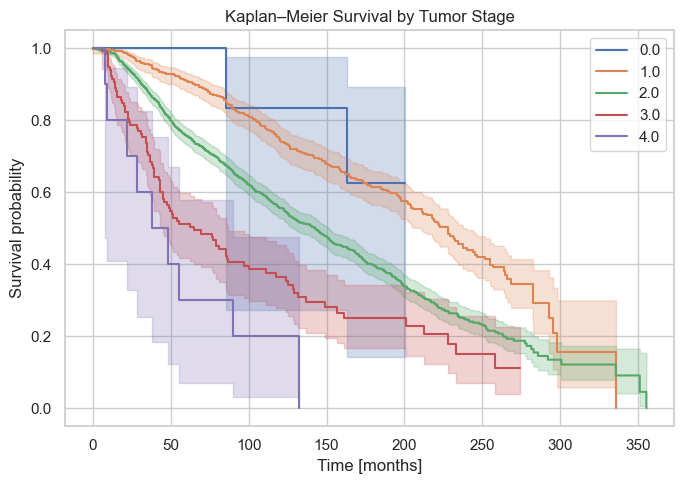

Log-rank p-value for Tumor Stage: 5.883e-28


In [75]:
print("Unique Tumor Stages:", df["Tumor Stage"].unique())

stages_order = sorted(
    [s for s in df["Tumor Stage"].dropna().unique()]
)

km_by_group(
    df,
    group_col="Tumor Stage",
    title="Kaplan–Meier Survival by Tumor Stage",
    order=stages_order
)


##### The graph above visualizes the survival rate of patients with different tumor stages. As we can see all types of patients start decreasing gradually with the exception of stage 0, stage 0 tumors are uninvasive meaning it has a better prognostic. 

##### We can see that patients with stage 0 breast cancer hardly die as more than 80% last 150 months and by 200 months more than 60% survive with the graph no longer tracking them, this does not mean that by 200 months patients that survive will no longer die to breast cancer rather it means by this time they were either lost, discharged or simply it was their most recent survival confirmation which is the mostly given the platues.

##### Another stage to understand is the stage 4 breast cancer, as patients with this tumor stage have the lowest survival rate. Before 150 months all the patients with this stage are either dead or lost due to the various plateus.

##### For the rest of the patients stages 1, 2, and 3, the survival rate decreases with few plateus (unknown data) although stage 3 patients are no longer tracked after 250 months by then they have less than 20% chance of survival and stages 1 and 2 continue until they are all deceased or lost with stage 1 patients reaching a survival rate slighly higher than stage 2 and 3 patients but still less than 20% at 300 months

Unique Chemotherapy values: ['NO' 'YES' 'Unknown']


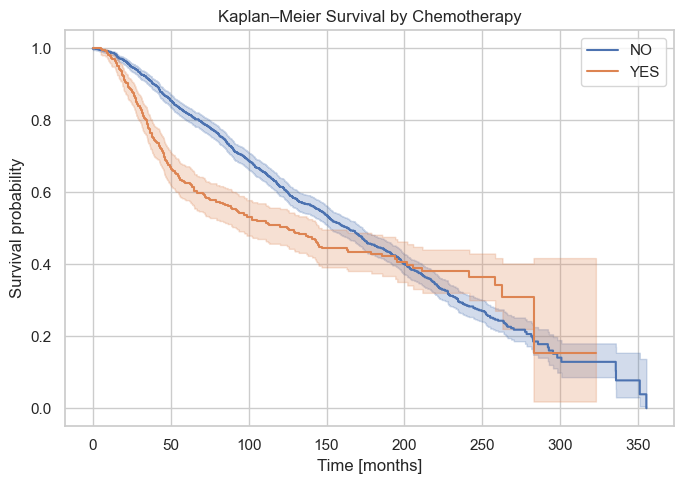

Log-rank p-value for Chemotherapy: 0.001794


In [76]:
print("Unique Chemotherapy values:", df["Chemotherapy"].unique())

chemo_order = ["NO", "YES", "Unknown"]

km_by_group(
    df,
    group_col="Chemotherapy",
    title="Kaplan–Meier Survival by Chemotherapy",
    order=chemo_order
)


##### The graph above shows the survival rate of patients of have been treated with chemotherapy. As we can see the patients without chemotherapy treatment have a higher survival rate than those with treatment up until 200 months where the survial rate of the patients with treatment begins to plateu indicating that there could be either there are case of a patients status becoming unknown or the patient was discharged. 

Unique ER Status values: ['Positive' 'Negative']


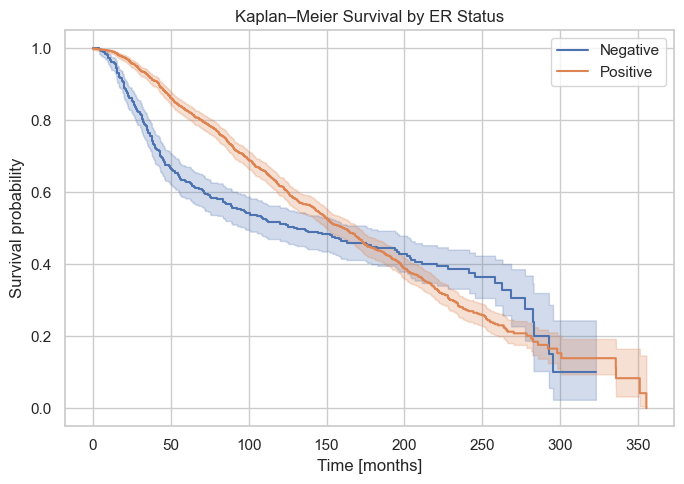

Log-rank p-value for ER Status: 0.03505


In [77]:
print("Unique ER Status values:", df["ER Status"].unique())

er_order = ["Negative", "Positive", "Unknown"]

km_by_group(
    df,
    group_col="ER Status",
    title="Kaplan–Meier Survival by ER Status",
    order=er_order
)


##### The graph above allows us to see the survival rate of the patients based on their Estrogen Recptor status. As time goes on the survival rates of both types of patients decreases gradually however the patients with a negative status or without endocrine therapy have lower survival rate than patients whose cancer cells express estrogen recptors or postive status. However this until 175 months pass, then patients without endocrine therapy have a slightly higher survival rate until they plateu at 300 months revealing either discharge or loss of patient data.

### Calibration

In [83]:
km_overall = KaplanMeierFitter(label="All METABRIC patients")
km_overall.fit(df["time"], event_observed=df["event"])

# Choose clinically meaningful horizons in months: 5, 10, 15 years
horizons = [60.0, 120.0, 180.0]

rows = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km_overall, t=t0)
    rows.append({
        "t0 [months]": int(t0),
        "RMST [months]": round(float(rmst_val), 1)
    })

rmst_overall_table = pd.DataFrame(rows)
print("\nRestricted Mean Survival Time (Overall):")
display(rmst_overall_table)



Restricted Mean Survival Time (Overall):


,t0 [months],RMST [months]
0,60,54.4
1,120,95.7
2,180,126.7


In [84]:
km_train = KaplanMeierFitter(label="Train")
km_train.fit(y_time_train, event_observed=y_event_train)

median_survival_train = km_train.median_survival_time_
print(f"Train median survival: {median_survival_train:.1f} months")

rows_train = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km_train, t=t0)
    rows_train.append({
        "t0 [months]": int(t0),
        "RMST_train [months]": round(float(rmst_val), 1)
    })
rmst_train_table = pd.DataFrame(rows_train)

km_test = KaplanMeierFitter(label="Test")
km_test.fit(y_time_test, event_observed=y_event_test)

median_survival_test = km_test.median_survival_time_
print(f"Test median survival: {median_survival_test:.1f} months")

rows_test = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km_test, t=t0)
    rows_test.append({
        "t0 [months]": int(t0),
        "RMST_test [months]": round(float(rmst_val), 1)
    })
rmst_test_table = pd.DataFrame(rows_test)

# Merge train/test RMST for easy comparison
rmst_compare = rmst_train_table.merge(rmst_test_table, on="t0 [months]")
print("\nRMST comparison (Train vs Test):")
display(rmst_compare)


Train median survival: 156.8 months
Test median survival: 152.1 months

RMST comparison (Train vs Test):


,t0 [months],RMST_train [months],RMST_test [months]
0,60,54.2,55.0
1,120,95.6,96.0
2,180,126.8,126.6


##### We found that on average patients survive ~54-55 months in the first 60 months, patients survive ~ 96 months out of the first 120 months, and patients survive ! 127 months out of the first 180 months. 

##### Seeing how the RMST values are nearly identical in both training and testing sets among the three cohorts indicates that the model has calibrated effectively with low variability between splits and strong stability for the survival estimates.